In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import dxpy

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

df_dict = {}

OBESITY_PHENOS = [
  'body_mass_index_bmi',
  'whr_adj_bmi',
  'bmi_impedance',
  'body_fat_percentage',
  'visceral_adipose_tissue_volume_vat',
  'abdominal_fat_ratio',
  'gynoid_tissue_fatp',
  'android_tissue_fatp',
  'total_tissue_fatp',
  'tissuefatp_androidgynoidratio'
]

genebass_file_dict = {
    'whr_adj_bmi': 'WHRadjBMI_custom-both_sexes--custom',
    'body_fat_percentage': '23099-both_sexes--irnt',
    'bmi_impedance': '23104-both_sexes--irnt',
    'body_mass_index_bmi': '21001-both_sexes--irnt',
    'visceral_adipose_tissue_volume_vat': '22407-both_sexes--irnt',
    'alanine_aminotransferase': '30620-both_sexes--irnt',
    
}

### S0. Define functions

In [42]:
def old1_get_saige_path(pheno, chrom, sex='both_sexes', assoc='variant'):
    if assoc=='variant':
        return f'/mnt/project/saige_pipeline/data/old-02_saige_variant_test/saige_variant_test.{pheno}{f"-{sex}" if sex != "both_sexes" else ""}.chr{chrom}.tsv'

def old2_get_saige_path(pheno, chrom, sex='both_sexes', assoc='gene_assoc'):
    return f'/mnt/project/saige_pipeline/data/02_saige_all_test/{sex}/saige_all_test.{pheno}{f"-{sex}" if sex != "both_sexes" else ""}.chr{chrom}.{assoc}_assoc.tsv'


def get_saige_path(pheno, chrom, sex='both_sexes', assoc='variant'):
    if assoc=='variant':
        return f'/mnt/project/saige_pipeline/data/02_saige_variant_test/saige_variant_test.{pheno}{f"-{sex}" if sex != "both_sexes" else ""}.chr{chrom}.tsv'
    elif assoc in {'gene','set'}:
        return f'/mnt/project/saige_pipeline/data/02_saige_set_test/saige_set_test.{pheno}{f"-{sex}" if sex != "both_sexes" else ""}.chr{chrom}.tsv'

    
def read_saige_gwas(pheno, sex='both'):

    df_list = []

    for chrom in list(range(1,23))+['X']:
        try:
            df_tmp = pd.read_csv(get_saige_path(pheno=pheno, chrom=chrom, sex=sex, assoc='variant'), sep='\t')
            df_list.append(df_tmp)
        except:
            print(f'No file for {pheno} sex={sex} chr{chrom}')
    df =  pd.concat(df_list, axis=0)
    df = df.rename(columns={'POS':'position'})
    df['CHISQ'] = (df.BETA/df.SE)**2
    df['nlog10pval'] = -np.log10(df['p.value'])
    df['maf'] = pd.concat([df['AF_Allele2'], 1-df['AF_Allele2']], axis=1).min(axis=1)
    
    return df

def read_saige_gene_assoc(pheno, sex='both_sexes'):

    df_list = []

    for chrom in list(range(1,23))+['X']:
        path = get_saige_path(pheno=pheno, chrom=chrom, sex=sex, assoc='set')
        try:
            df_tmp = pd.read_csv(path, sep='\t')
            df_list.append(df_tmp)
        except:
            print(f'No file for {pheno} sex={sex} chr{chrom}: {path}')
    df =  pd.concat(df_list, axis=0)
    
    return df

def read_genebass_results(pheno, assoc='variant'):
    genebass_suffix = genebass_file_dict[pheno]
    if assoc=='gene':
        gb = pd.read_csv(f'/mnt/project/saige_pipeline/data/genebass/gene-burden-results-exomes_pLoF_continuous-{genebass_suffix}.csv')
        gb = gb.rename(
            columns={
                'Gene Id':'Region',
                'P‑Value SKATO': 'Pvalue',
                'P‑Value Burden': 'Pvalue_Burden',
                'P‑Value SKAT': 'Pvalue_SKAT',
                'BETA Burden':'BETA_Burden',
                'Burden Set': 'Group'
            }
        )
    elif assoc=='variant':
        gb = pd.read_csv(f'/mnt/project/saige_pipeline/data/genebass/single-variant-associations-exomes_continuous-{genebass_suffix}.csv')
        gb['CHR'] = gb['Variant ID'].str.split('-', expand=True)[0]
        gb['position'] = gb['Variant ID'].str.split('-', expand=True)[1]
        gb['Allele1'] = gb['Variant ID'].str.split('-', expand=True)[2]
        gb['Allele2'] = gb['Variant ID'].str.split('-', expand=True)[3]
        
    return gb

def plot_manhattan(df, min_maf=1e-6, log_yscale=False, title=''):
    
    start_bp = 0
    mid = []
    chrom_list = []
    plt.figure(figsize=(12, 8))
    for i, chrom in enumerate(range(1, 24)):
        if chrom==23: chrom='X'
            
        gwas = df[df.CHR==chrom]
        
#         print(f'Variants with defined p-values chr{chrom}: {gwas.nlog10pval.notna().sum()}')
        
        plt.plot(gwas['position']+start_bp,
                 gwas['nlog10pval'], '.', c=COLORS[i % 2])
        mid.append(start_bp+(max(gwas['position']))/2)
        start_bp += max(gwas['position'])
        start_bp += 5e7
        chrom_list.append(chrom)

    left, right = plt.xlim()
    plt.plot([left, right], [-np.log10(5e-7)]*2, 'k--')
    plt.plot([left, right], [-np.log10(0.05/df['p.value'].notna().sum())]*2, 'k--', alpha=0.2)
    plt.xticks(mid, chrom_list)
    plt.title(title)
    plt.xlabel('Chromosome')
    plt.ylabel('-log10(p)')
    plt.xlim([left, right])
    _, ymax = plt.ylim()
    if log_yscale:
        plt.yscale('symlog', linthresh=5)
        plt.ylim([0, ymax**1.05])


def plot_miami(df1, df2, min_maf=1e-6, log_yscale=False, title=''):
    
    start_bp = 0
    mid = []
    chrom_list = []
    plt.figure(figsize=(12, 8))
    for chrom_i, chrom in enumerate(range(1, 24)):
        if chrom==23: chrom='X'
            
        max_pos=0
        for i, df in enumerate([df1, df2]):
            try:
                gwas = df[df.CHR==chrom]

    #             print(f'GWAS {i+1}: Variants with defined p-values chr{chrom}: {gwas.nlog10pval.notna().sum()}')

                plt.plot(
                    gwas['position']+start_bp,
                     ((-1)**i)*gwas['nlog10pval'],  # flip second GWAS to be below
                    '.', c=COLORS[chrom_i % 2]
                )
                max_pos = max(max_pos, max(gwas['position']))
            except:
                print(f'Failed: GWAS {i+1} chr{chrom}')
        mid.append(start_bp+(max_pos)/2)
        start_bp += max_pos
        start_bp += 5e7
        chrom_list.append(chrom)

    left, right = plt.xlim()
    for i in range(2):
        plt.plot([left, right], [-np.log10(5e-7)*(-1)**i]*2, 'k--')
        plt.plot([left, right], [-np.log10(0.05/df['p.value'].notna().sum())*(-1)**i]*2, 'k--', alpha=0.2)
    plt.xticks(mid, chrom_list)
    plt.title(title)
    plt.xlabel('Chromosome')
    plt.ylabel('-log10(p)')
    plt.xlim([left, right])
    _, ymax = plt.ylim()
    if log_yscale:
        plt.yscale('symlog', linthresh=5)
        plt.ylim([0, ymax**1.05])
        
        
def plot_qq(df, nlog10pval_field = 'nlog10pval', maf_bins=None, logscale=False, figsize=(9*1.2,6*1.2), dpi=100, title=''):
    r'''Makes QQ plot for fields in `fields`.

    maf_bins should be a list of tuples, indicating min and max MAF per bin.
    Plots y-axis/x-axis in log scale if `logscale`=True.
    '''
    def get_expected(n):
        """Get expected -log10(p) for `n` observations
        """
        exp = -np.log10(np.linspace(start=1,stop=1/n,num=n)) # to account for weird kink at lower end in log-log scale: -np.log10(np.linspace(start=1-1/df_tmp.shape[0],stop=1/df_tmp.shape[0],num=df_tmp.shape[0]))

        return exp

    # Make 95% confidence interval
    def get_CI_intervals(n, CI=0.95):
        k = np.arange(1,n+1)
        a = k
        b = n+1-k
        intervals=stats.beta.interval(CI, a, b) # get 95% CI with parameters a and b
        return intervals

    def get_lambda_gc(chisq_vec):
        return np.median(chisq_vec)/stats.chi2.ppf(q=0.5, df=1)

    df = df[df[nlog10pval_field].notna()].copy()

    n = df.shape[0]
    exp = get_expected(n)
    intervals = get_CI_intervals(n)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(exp,exp,'k--')
    plt.fill_between(
        x=exp[::-1], # need to reverse order of array exp to match intervals
        y1=-np.log10(intervals[0]),
        y2=-np.log10(intervals[1]),
        color='k',
        alpha=0.1,
        label='Expected'
    )

    lambda_gc_dict = {}

    if maf_bins is None:
        exp = get_expected(n=n)
        rank = np.sort(df[nlog10pval_field])
        ax.scatter(exp, rank, label='Observed')
    else:
        for i, (maf_min, maf_max) in enumerate(maf_bins):
            df_tmp = df[(df.maf>maf_min)&(df.maf<=maf_max)]

            n_tmp = df_tmp[nlog10pval_field].notna().sum()
            exp_tmp = get_expected(n_tmp)
            rank_tmp = np.sort(df_tmp[nlog10pval_field])

            lambda_gc_tmp = get_lambda_gc(chisq_vec=df_tmp['CHISQ'])
            lambda_gc_dict[f'({maf_min}, {maf_max}]'] = lambda_gc_tmp

            ax.scatter(
                exp_tmp,
                rank_tmp,
                color=plt.cm.viridis(i/(len(maf_bins)-0.5)),
                label=f'MAF:({maf_min}, {maf_max}]'+r', $\lambda_{GC}=$'+f'{lambda_gc_tmp:.2e}'
            )

    if logscale:
        plt.yscale('log')
        plt.xscale('log')

#    plt.ylim([min(-np.log10(intervals[0])),max(-np.log10(intervals[1]))])
    plt.xlabel(r'Expected -$\log_{10}(p)$')
    plt.ylabel(r'Observed -$\log_{10}(p)$')
    plt.legend(loc='upper left')

    lambda_gc_dict['all'] = get_lambda_gc(chisq_vec=df['CHISQ'])
    plt.title(title+r'$\lambda_{GC}='+f'{lambda_gc_dict["all"]:.2e}$')

    return df, lambda_gc_dict

def compare_to_genebass(df_dict, pheno, assoc='variant'):
    if assoc=='variant':
        gwas_id_genebass = pheno+'-genebass'

        if gwas_id_genebass not in df_dict:
            df_dict[gwas_id_genebass] = read_genebass_results(pheno=pheno, assoc='variant')
        if pheno not in df_dict:
            df_dict[pheno] = read_saige_gwas(pheno)

        df = df_dict[pheno]
        df_genebass = df_dict[gwas_id_genebass]      

        def uniq_varid(row):
            alleles = '-'.join(sorted([row.Allele1, row.Allele2]))
            return f'{row.CHR}-{row.position}-{alleles}'

        df['varid'] = df.apply(uniq_varid, axis=1)
        df_genebass['varid'] = df_genebass.apply(uniq_varid, axis=1)
        merged = df.merge(df_genebass, on='varid')

        plt.figure(dpi=300)
        plt.scatter(
            -np.log10(merged['P-Value']), 
            merged.nlog10pval, alpha=0.5)
        ymin, ymax = plt.ylim()
        xmin, xmax = plt.xlim()
        plt.plot(*[[xmin, xmax]]*2, 'k--')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.title(f'{pheno} (variant-level)')
        plt.xlabel('Genebass -log10(pval)')
        plt.ylabel('Lindgren -log10(pval)')

    elif assoc in {'gene','set'}:
        gwas_id_genebass = pheno+'-genebass'

        if gwas_id_genebass not in df_dict:
            df_dict[gwas_id_genebass] = read_genebass_results(pheno=pheno, assoc='gene')
        if pheno not in df_dict:
            df_dict[pheno] = read_saige_gene_assoc(pheno=pheno)

        df = df_dict[pheno]
        df_genebass = df_dict[gwas_id_genebass]      

        df_subset = df[
            (df.Group=='pLoF')
            &(df.max_MAF==0.001)
        ]

        merged = df_subset.merge(df_genebass, on='Region', suffixes=('','_genebass'))

        plt.figure(figsize=(6,4), dpi=300)
        plt.scatter(-np.log10(merged.Pvalue_SKAT), -np.log10(merged.Pvalue_SKAT_genebass), alpha=0.5)
        ymin, ymax = plt.ylim()
        xmin, xmax = plt.xlim()
        plt.plot(*[[xmin, xmax]]*2, 'k--')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.title(pheno)
        plt.xlabel('Genebass -log10(pval SKAT)')
        plt.ylabel('Lindgren -log10(pval SKAT)')
    
    return merged, df, df_genebass

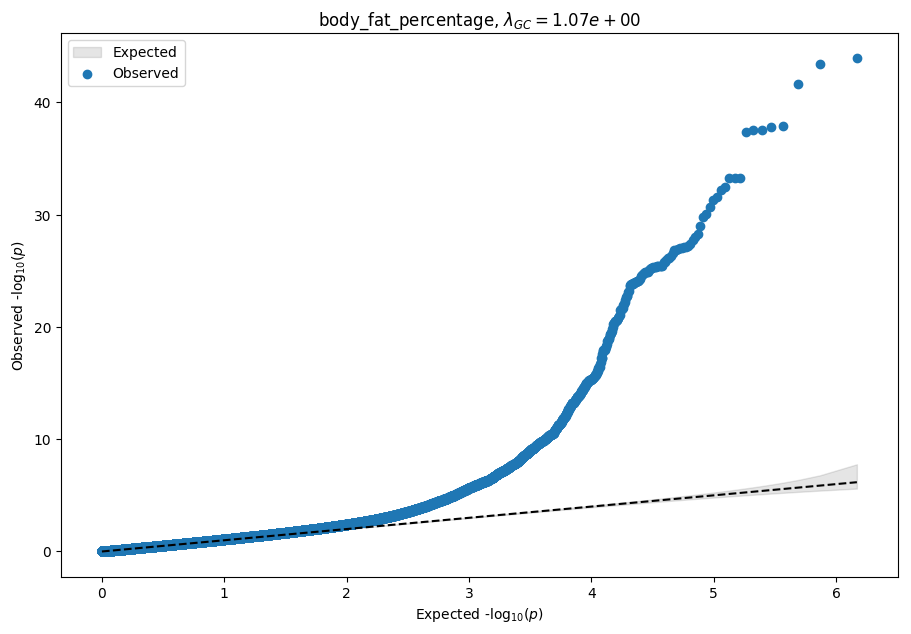

In [20]:
pheno='whr'

df_dict[pheno] = read_saige_gwas(pheno)
df = df_dict[pheno]
df, lambda_gc_dict = plot_qq(df=df)
plt.title(f'{pheno} '+r'($\lambda_{GC}='+f'{lambda_gc_dict["all"]:.2e}$)')

Variants with defined p-values chr1: 23088
Variants with defined p-values chr2: 15719
Variants with defined p-values chr3: 12794
Variants with defined p-values chr4: 8903
Variants with defined p-values chr5: 10016
Variants with defined p-values chr6: 12865
Variants with defined p-values chr7: 10841
Variants with defined p-values chr8: 8448
Variants with defined p-values chr9: 10265
Variants with defined p-values chr10: 9444
Variants with defined p-values chr11: 14932
Variants with defined p-values chr12: 11854
Variants with defined p-values chr13: 3963
Variants with defined p-values chr14: 7310


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Variants with defined p-values chr15: 7652
Variants with defined p-values chr16: 12276
Variants with defined p-values chr17: 14388
Variants with defined p-values chr18: 3673
Variants with defined p-values chr19: 18681
Variants with defined p-values chr20: 6758
Variants with defined p-values chr21: 2911
Variants with defined p-values chr22: 6031
Variants with defined p-values chrX: 4363


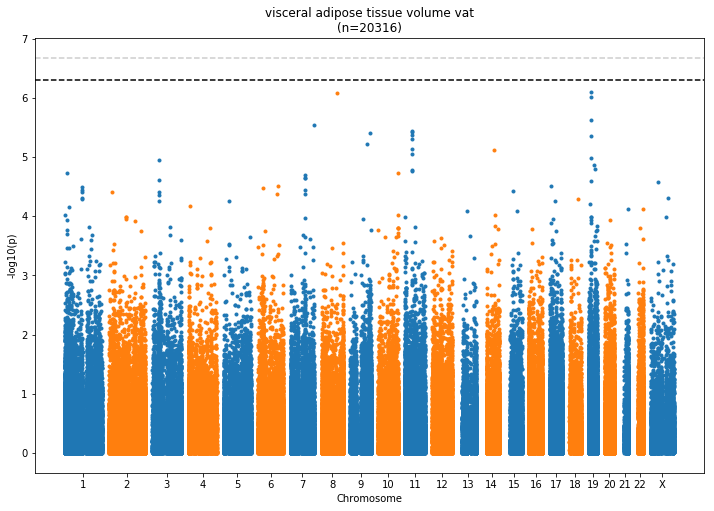

In [3]:
pheno='visceral_adipose_tissue_volume_vat'
if pheno not in df_dict:
    df_dict[pheno] = read_saige_gwas(pheno)
plot_manhattan(df=df_dict[pheno])
_ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(n={int(df_dict[pheno].N.mean())})')

Variants with defined p-values chr1: 22814
Variants with defined p-values chr2: 15579
Variants with defined p-values chr3: 12656
Variants with defined p-values chr4: 8807
Variants with defined p-values chr5: 9933
Variants with defined p-values chr6: 12749
Variants with defined p-values chr7: 10693
Variants with defined p-values chr8: 8372
Variants with defined p-values chr9: 10170
Variants with defined p-values chr10: 9359
Variants with defined p-values chr11: 14772
Variants with defined p-values chr12: 11725
Variants with defined p-values chr13: 3910
Variants with defined p-values chr14: 7241
Variants with defined p-values chr15: 7557
Variants with defined p-values chr16: 12131
Variants with defined p-values chr17: 14246
Variants with defined p-values chr18: 3635
Variants with defined p-values chr19: 18477
Variants with defined p-values chr20: 6699
Variants with defined p-values chr21: 2888
Variants with defined p-values chr22: 5972
Variants with defined p-values chrX: 4315


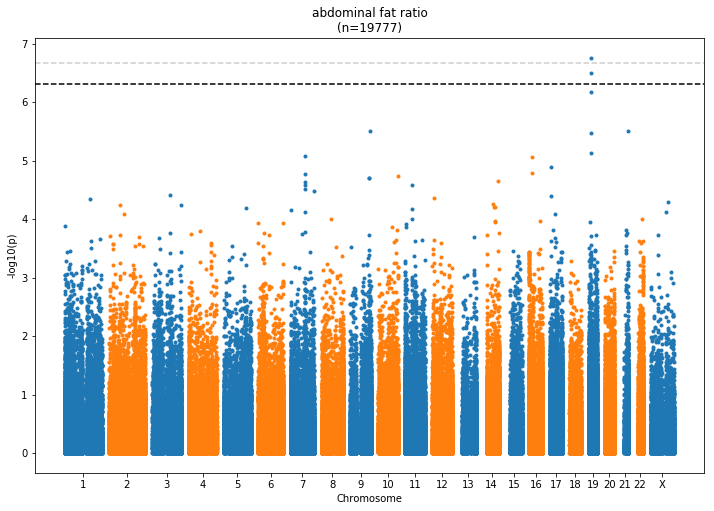

In [4]:
pheno='abdominal_fat_ratio'
if pheno not in df_dict:
    df_dict[pheno] = read_saige_gwas(pheno)
plot_manhattan(df=df_dict[pheno])
_ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(n={int(df_dict[pheno].N.mean())})')

In [ ]:
maf_thresholds = [1e-6, 0.0001, 0.001, 0.01, 0.5]
maf_bins = list(zip(maf_thresholds[:-1], maf_thresholds[1:]))

for pheno in OBESITY_PHENOS:
    for sex in ['both','female','male']:
        gwas_id=pheno+sex
        try:
            print(f'Starting {pheno}, sex={sex}')
            if gwas_id not in df_dict:
                df_dict[gwas_id] = read_saige_gwas(pheno, sex=sex)
            df, lambda_gc_dict = plot_qq(df=df_dict[gwas_id], maf_bins=maf_bins)
            plt.title(f'{pheno.replace("_"," ")}, sex={sex}\n'+f'(n={int(df.N.mean())}, '+r'$\lambda_{GC}='+f'{lambda_gc_dict["all"]:.2e}$)')

            fname=f'qq_plot.with_maf_bins.{pheno}{f"-{sex}" if sex!="both" else ""}.png'
            plt.savefig(f'/opt/notebooks/{fname}', dpi=300)
            dxpy.upload_local_file(
                filename=f'/opt/notebooks/{fname}',
                name=fname,
                folder='/saige_pipeline/plots/',
                parents=True
            )
        except:
            print(f'Failed {pheno}, sex={sex}')

No file for body_fat_percentage sex=female chr1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in long_scalars
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in long_scalars
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in long_scalars
/opt/conda/lib/python3.6/site-packages/

Variants with defined p-values chr1: 146449
Variants with defined p-values chr2: 100147
Variants with defined p-values chr3: 82437
Variants with defined p-values chr4: 54591
Variants with defined p-values chr5: 61065
Variants with defined p-values chr6: 71328
Variants with defined p-values chr7: 68149
Variants with defined p-values chr8: 54248
Variants with defined p-values chr9: 64589
Variants with defined p-values chr10: 57418
Variants with defined p-values chr11: 94441
Variants with defined p-values chr12: 75332
Variants with defined p-values chr13: 24461
Variants with defined p-values chr14: 45781
Variants with defined p-values chr15: 48504
Variants with defined p-values chr16: 79277
Variants with defined p-values chr17: 92501
Variants with defined p-values chr18: 22414
Variants with defined p-values chr19: 116542
Variants with defined p-values chr20: 41892
Variants with defined p-values chr21: 17650
Variants with defined p-values chr22: 38047
Variants with defined p-values chrX: 3

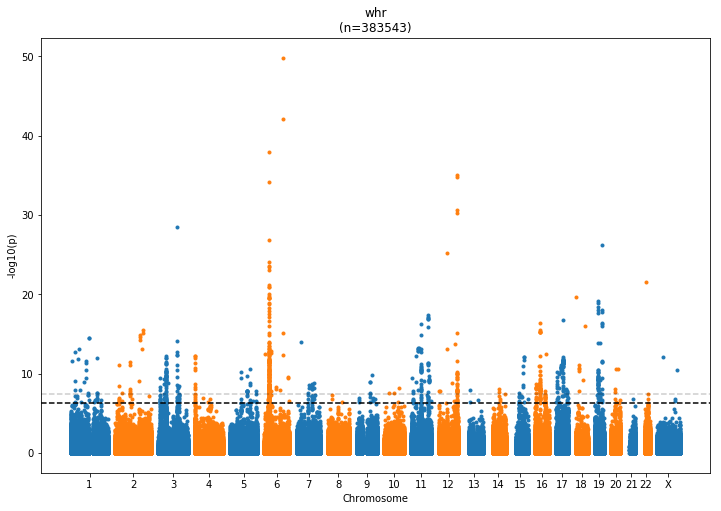

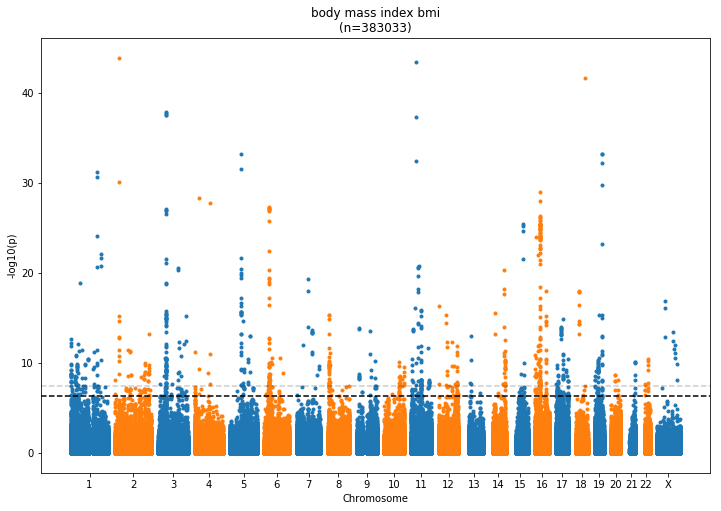

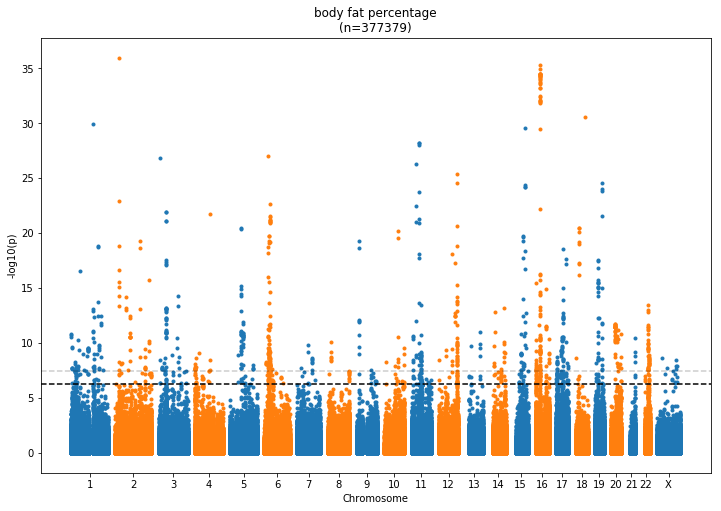

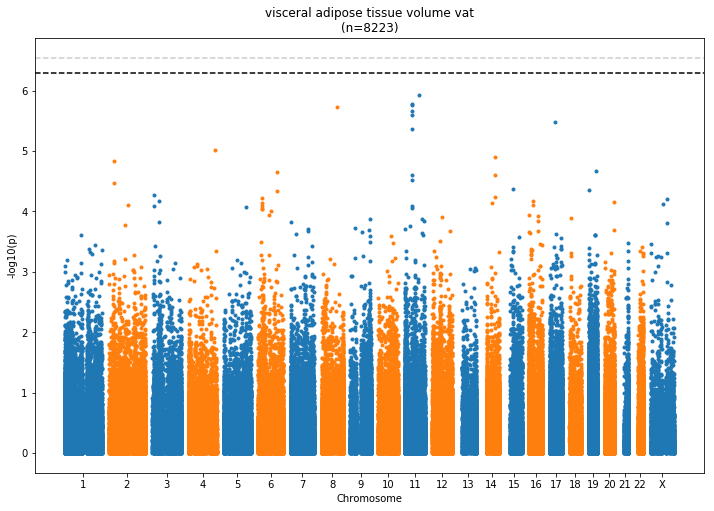

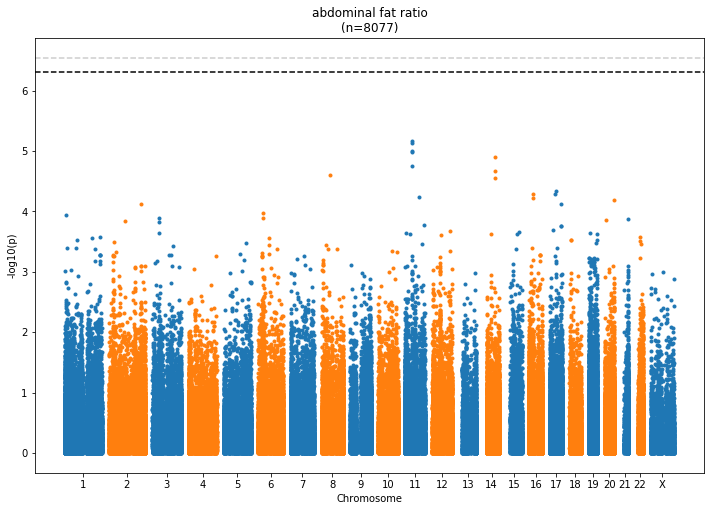

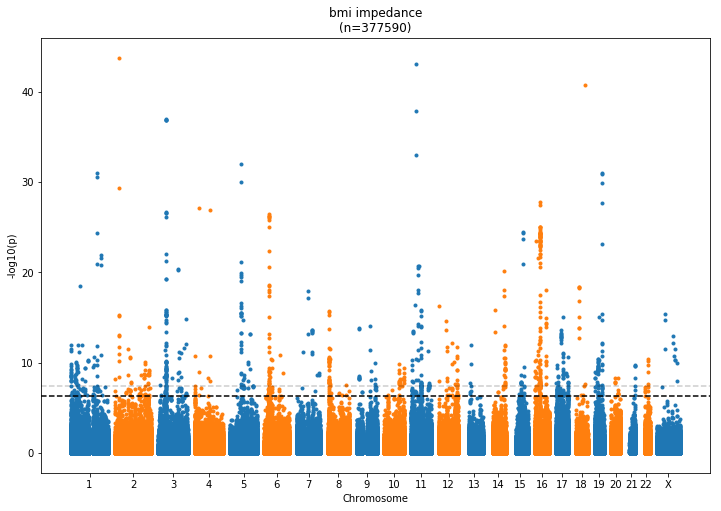

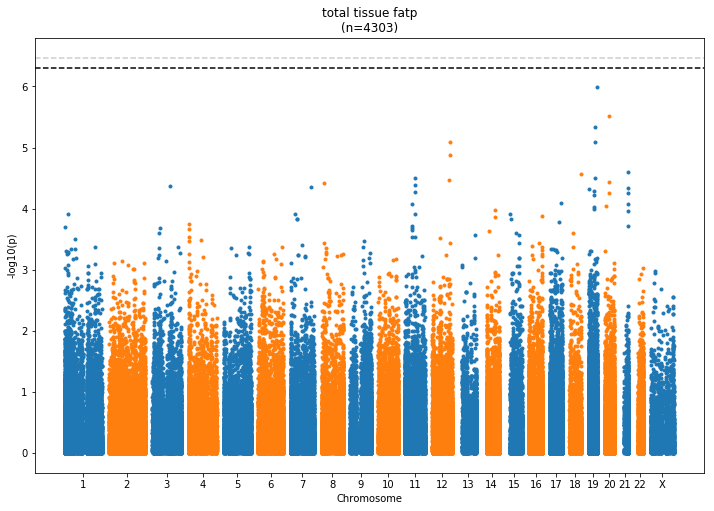

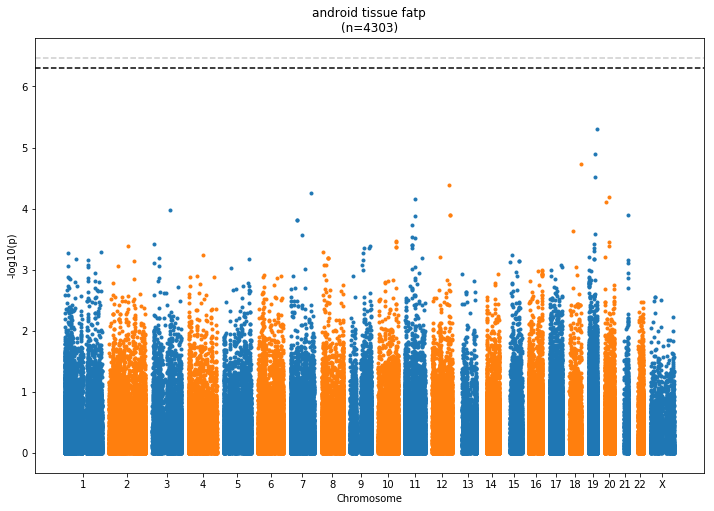

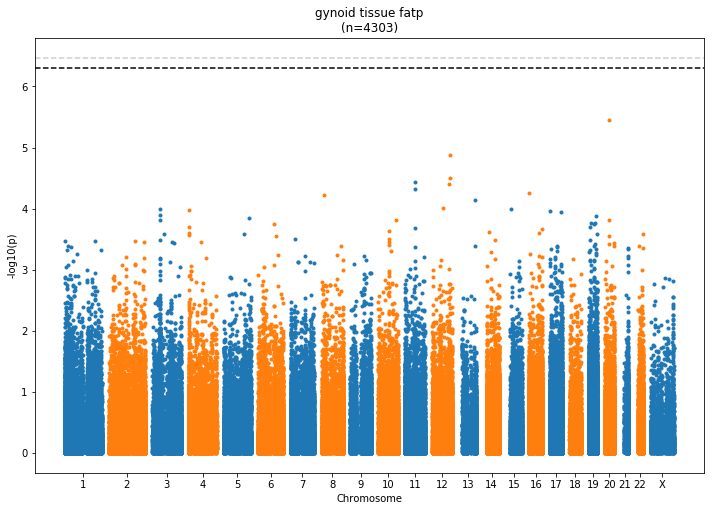

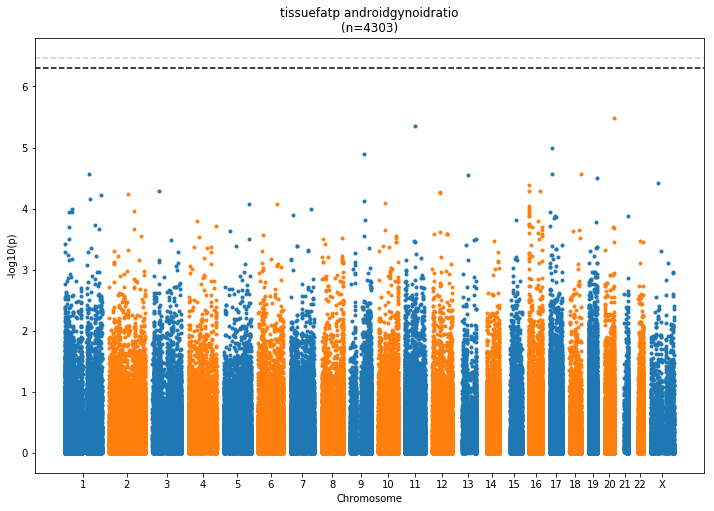

In [37]:
for pheno in OBESITY_PHENOS:
    if pheno not in df_dict:
        df_dict[pheno] = read_saige_gwas(pheno)
    plot_manhattan(df=df_dict[pheno])
    _ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(n={int(df_dict[pheno].N.mean())})')
    
    fname=f'manhattan_plot.{pheno}.png'
    plt.savefig(f'/opt/notebooks/{fname}', dpi=300)
    dxpy.upload_local_file(
        filename=f'/opt/notebooks/{fname}',
        name=fname,
        folder='/saige_pipeline/plots/',
        parents=True
    )

### Sex-stratified Miami plots

In [ ]:
for pheno in OBESITY_PHENOS:
    try:
        for sex in ['male','female']:
            gwas_id = pheno+sex
            if pheno not in df_dict:
                df_dict[gwas_id] = read_saige_gwas(pheno, sex=sex)
        df_f = df_dict[pheno+'female']
        df_m = df_dict[pheno+'male']

        plot_miami(df1=df_f, df2=df_m)
        _ = plt.title(f'{pheno.replace("_"," ")}\n'+f'(TOP: females={int(df1.N.mean())}, BOTTOM: males={int(df2.N.mean())})')

        fname=f'miami_plot.{pheno}-sexstrat.png'
        plt.savefig(f'/opt/notebooks/{fname}', dpi=300)
        dxpy.upload_local_file(
            filename=f'/opt/notebooks/{fname}',
            name=fname,
            folder='/saige_pipeline/plots/',
            parents=True
        )
    except:
        print(f'Failed {pheno}')

## Compare to Genebass

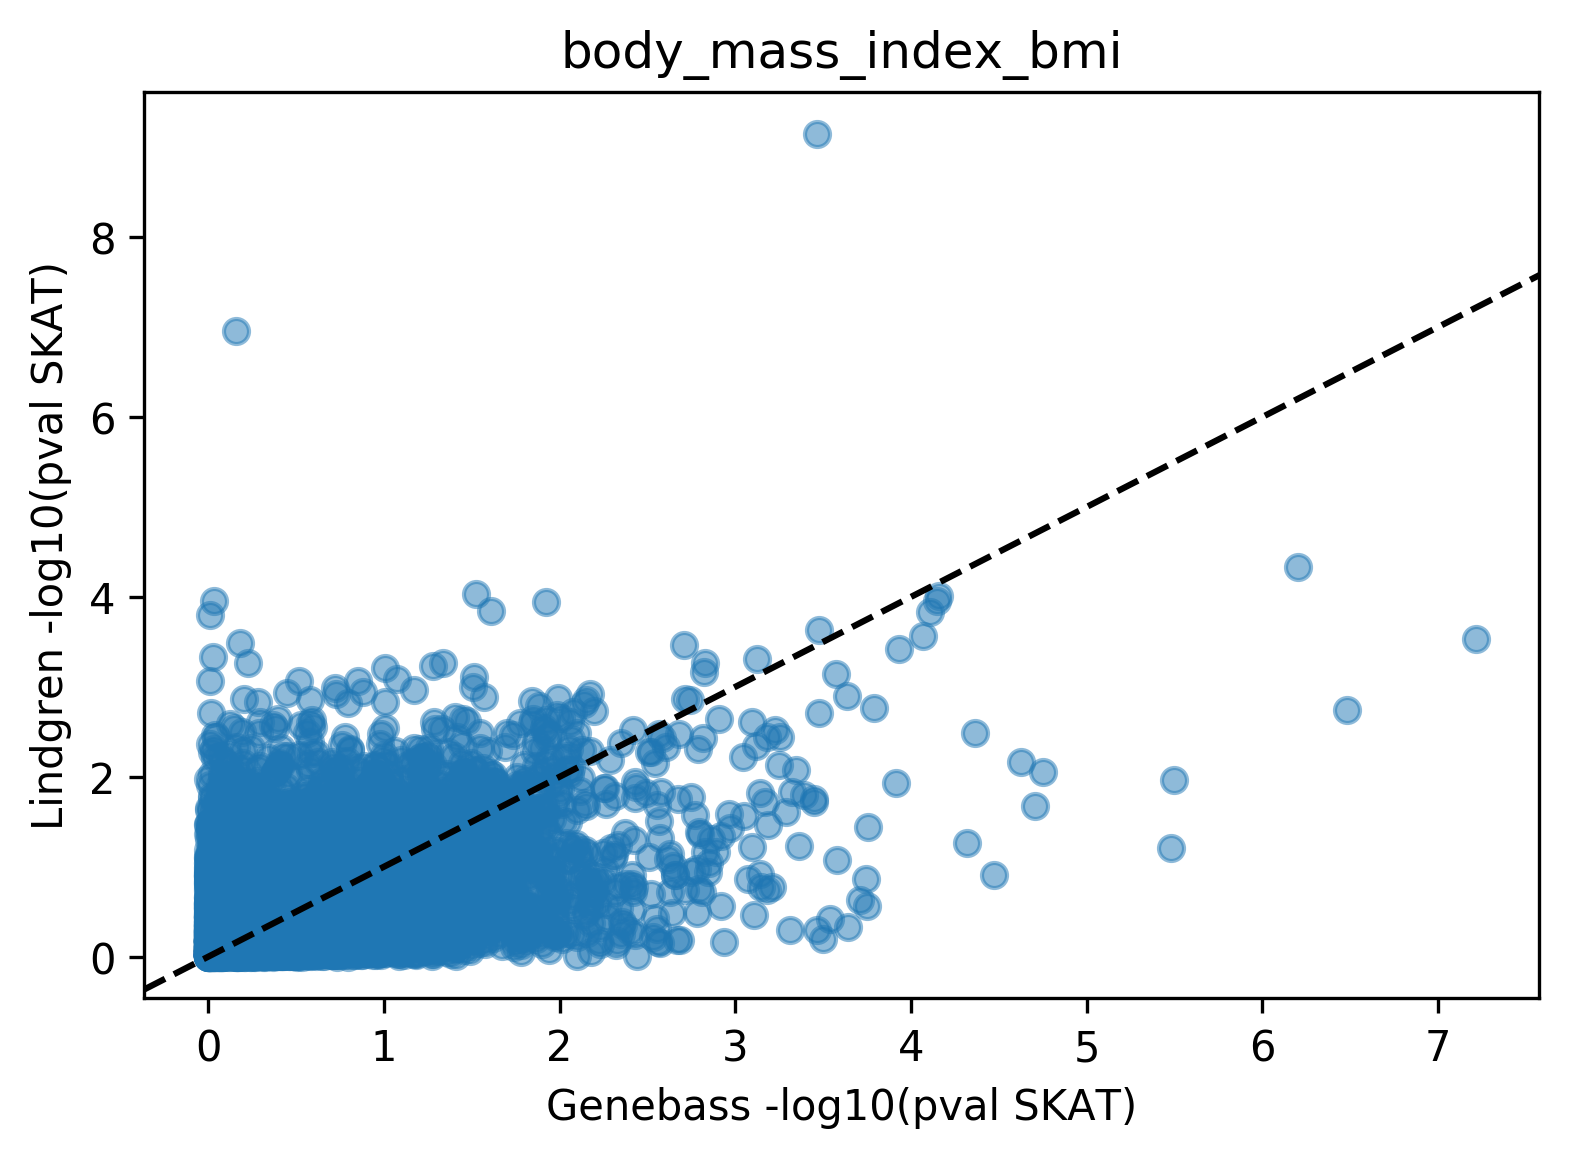

In [41]:
merged, df, df_genebass = compare_to_genebass(df_dict=df_dict, pheno='body_mass_index_bmi', assoc='gene')

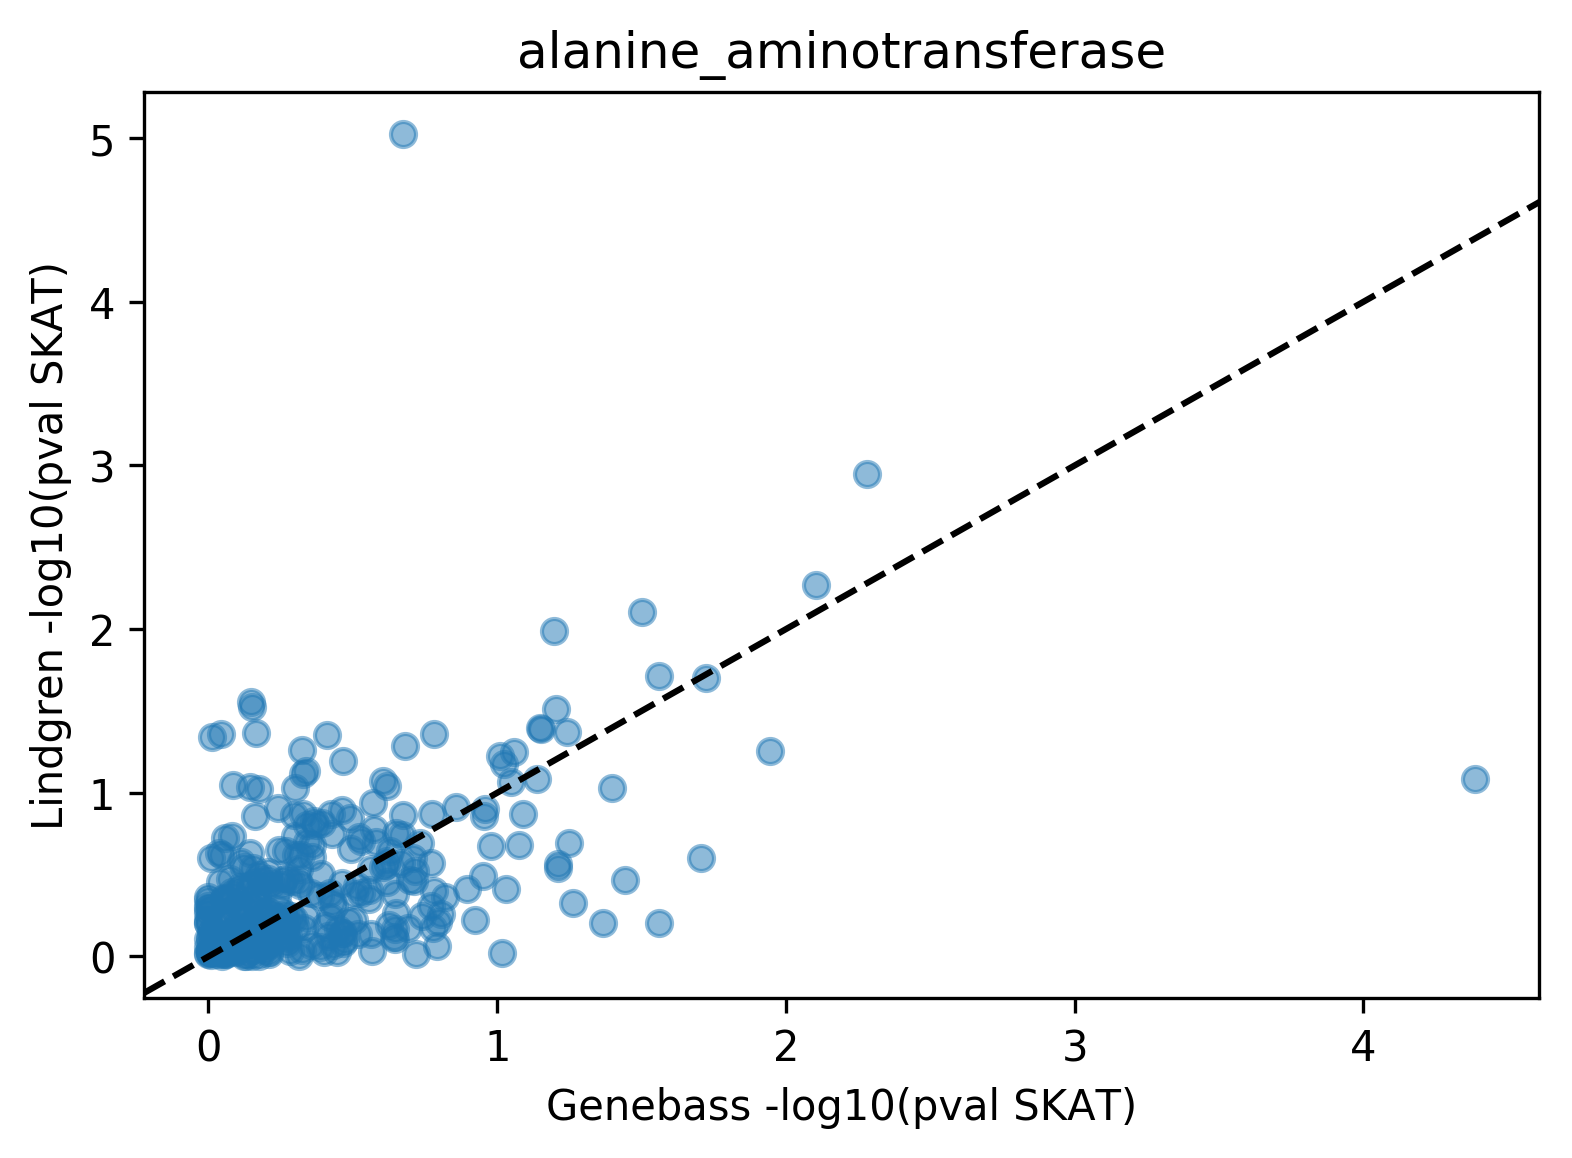

In [43]:
merged, df, df_genebass = compare_to_genebass(df_dict=df_dict, pheno='alanine_aminotransferase', assoc='gene')

## Set-based tests

In [12]:
def compare_to_genebass(df_dict, pheno, assoc='gene'):

    gwas_id_genebass = pheno+'-genebass'

    if gwas_id_genebass not in df_dict:
        df_dict[gwas_id_genebass] = read_genebass_results(pheno=pheno, assoc='gene')
    if pheno not in df_dict:
        df_dict[pheno] = read_saige_gwas(pheno)

    df = df_dict[pheno]
    df_genebass = df_dict[gwas_id_genebass]      
                        
    def uniq_varid(row):
        alleles = '-'.join(sorted([row.Allele1, row.Allele2]))
        return f'{row.CHR}-{row.position}-{alleles}'
    
    df['varid'] = df.apply(uniq_varid, axis=1)
    df_genebass['varid'] = df_genebass.apply(uniq_varid, axis=1)
    merged = df.merge(df_genebass, on='varid')

    plt.figure(dpi=300)
    plt.scatter(
        -np.log10(merged['P-Value']), 
        merged.nlog10pval, alpha=0.5)
    ymin, ymax = plt.ylim()
    xmin, xmax = plt.xlim()
    plt.plot(*[[xmin, xmax]]*2, 'k--')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(pheno)
    plt.xlabel('Genebass -log10(pval)')
    plt.ylabel('Lindgren -log10(pval)')

In [13]:
pheno = 'body_fat_percentage'
gb = read_genebass_results(pheno=pheno, assoc='gene')
df = read_saige_gene_assoc(pheno=pheno, sex='both')

No file for body_fat_percentage sex=both chr1: /mnt/project/saige_pipeline/data/02_saige_set_test/saige_set_test.body_fat_percentage-both.chr1.tsv
No file for body_fat_percentage sex=both chr2: /mnt/project/saige_pipeline/data/02_saige_set_test/saige_set_test.body_fat_percentage-both.chr2.tsv
No file for body_fat_percentage sex=both chr3: /mnt/project/saige_pipeline/data/02_saige_set_test/saige_set_test.body_fat_percentage-both.chr3.tsv
No file for body_fat_percentage sex=both chr4: /mnt/project/saige_pipeline/data/02_saige_set_test/saige_set_test.body_fat_percentage-both.chr4.tsv
No file for body_fat_percentage sex=both chr5: /mnt/project/saige_pipeline/data/02_saige_set_test/saige_set_test.body_fat_percentage-both.chr5.tsv
No file for body_fat_percentage sex=both chr6: /mnt/project/saige_pipeline/data/02_saige_set_test/saige_set_test.body_fat_percentage-both.chr6.tsv
No file for body_fat_percentage sex=both chr7: /mnt/project/saige_pipeline/data/02_saige_set_test/saige_set_test.body_

ValueError: No objects to concatenate

In [7]:
gb

,Gene Name,Region,Pvalue,Pvalue_Burden,Pvalue_SKAT,BETA_Burden,Group,Chrom : Position,Chrom,Position,Details
0,PLIN4,ENSG00000167676,3.803325e-10,1.534954e-09,4.883149e-09,-0.002877,pLoF,1.900450e+10,19,4497887.0,NaN
1,FBXL16,ENSG00000127585,1.010357e-09,1.588179e-03,1.613235e-10,0.025612,pLoF,1.600069e+10,16,687503.0,NaN
2,RIF1,ENSG00000080345,3.736082e-08,5.001011e-08,2.918500e-03,0.018048,pLoF,2.151410e+09,2,151410356.0,NaN
3,GPR151,ENSG00000173250,6.270972e-08,9.569518e-08,8.426561e-08,-0.002031,pLoF,5.146509e+09,5,146509132.0,NaN
4,PDE3B,ENSG00000152270,1.340336e-07,1.072834e-07,3.553094e-07,0.004826,pLoF,1.101464e+10,11,14643928.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
18353,CSKMT,ENSG00000214756,NaN,NaN,NaN,NaN,pLoF,NaN,NaN,NaN,NaN
18354,EEF1G,ENSG00000254772,NaN,NaN,NaN,NaN,pLoF,NaN,NaN,NaN,NaN
18355,AP001458.2,ENSG00000255432,NaN,NaN,NaN,NaN,pLoF,NaN,NaN,NaN,NaN
18356,NDUFA7,ENSG00000267855,NaN,NaN,NaN,NaN,pLoF,NaN,NaN,NaN,NaN


No file for body_mass_index_bmi sex=both chr1
No file for body_mass_index_bmi sex=both chr2
No file for body_mass_index_bmi sex=both chr3
No file for body_mass_index_bmi sex=both chr5
No file for body_mass_index_bmi sex=both chr6
No file for body_mass_index_bmi sex=both chr7
No file for body_mass_index_bmi sex=both chr19
No file for body_mass_index_bmi sex=both chrX


In [26]:
synon = df[(df['Group']=='synonymous')&(df['max_MAF']==0.01)]

In [29]:
plof = df[(df['Group']=='pLoF')&(df['max_MAF']==0.01)]

In [27]:
nonsynon = df[(df['Group']=='pLoF;damaging_missense')&(df['max_MAF']==0.01)]

In [28]:
merged = synon.merge(nonsynon, on=['Region','max_MAF'], suffixes=('_syn','_nonsyn'))

In [30]:
merged = synon.merge(plof, on=['Region','max_MAF'], suffixes=('_syn','_plof'))

In [13]:
plt.figure(dpi=300)
# plt.scatter(merged.Pvalue_syn, merged.Pvalue_nonsyn, s=2, alpha=0.2)
plt.hist(np.log10(merged.Pvalue_syn), 50)
_ = plt.hist(np.log10(merged.Pvalue_plof), 50)

NameError: name 'merged' is not defined

<Figure size 1800x1200 with 0 Axes>

In [40]:
plof.sort_values(by='Pvalue').iloc[:20,:]

,Region,Group,max_MAF,Pvalue,Pvalue_Burden,Pvalue_SKAT,BETA_Burden,SE_Burden,MAC,Number_rare,Number_ultra_rare
7598,ENSG00000166819,pLoF,0.01,5.805136e-12,4.974552e-12,2.874467e-07,-0.007295,0.001056,808.0,12.0,35.0
495,ENSG00000101745,pLoF,0.01,2.152104e-10,5.465068e-11,5.445056e-09,0.011914,0.001817,272.0,5.0,102.0
3507,ENSG00000204614,pLoF,0.01,1.342078e-07,2.149447e-07,1.904034e-07,0.002654,0.000512,4600.0,5.0,13.0
7473,ENSG00000146830,pLoF,0.01,1.368145e-07,9.699989e-08,6.694162e-06,0.013924,0.002611,132.0,1.0,76.0
9404,ENSG00000173250,pLoF,0.01,5.769864e-07,5.097171e-07,7.186671e-06,-0.001975,0.000393,7997.0,15.0,20.0
3694,ENSG00000152270,pLoF,0.01,1.973790e-06,2.217116e-06,1.679630e-05,-0.004704,0.000994,945.0,6.0,39.0
6366,ENSG00000217128,pLoF,0.01,5.326421e-06,5.326421e-06,5.326421e-06,-0.021876,0.004806,39.0,0.0,32.0
17259,ENSG00000036672,pLoF,0.01,5.834296e-06,4.835225e-02,4.338870e-06,0.004885,0.002474,146.0,3.0,28.0
3177,ENSG00000171105,pLoF,0.01,6.484969e-06,1.359293e-05,9.963390e-06,-0.011194,0.002573,136.0,2.0,47.0
3249,ENSG00000005810,pLoF,0.01,1.313302e-05,5.911488e-05,1.449256e-05,0.011453,0.002852,110.0,2.0,57.0


In [39]:
synon.sort_values(by='Pvalue')

,Region,Group,max_MAF,Pvalue,Pvalue_Burden,Pvalue_SKAT,BETA_Burden,SE_Burden,MAC,Number_rare,Number_ultra_rare
12535,ENSG00000189367,synonymous,0.01,1.245535e-12,6.037637e-12,4.624590e-13,0.002688,0.000391,8225.0,30.0,96.0
5284,ENSG00000124102,synonymous,0.01,3.321182e-05,2.728314e-05,1.383725e-03,-0.002976,0.000709,1842.0,12.0,19.0
2703,ENSG00000161960,synonymous,0.01,4.721675e-05,1.958273e-05,2.640298e-03,0.003501,0.000820,1369.0,24.0,78.0
1276,ENSG00000205639,synonymous,0.01,5.159427e-05,1.509183e-02,4.453090e-05,-0.001029,0.000423,5920.0,37.0,89.0
5702,ENSG00000179958,synonymous,0.01,6.693309e-05,4.851186e-05,1.894397e-04,0.007702,0.001896,250.0,5.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...
2695,ENSG00000128951,synonymous,0.01,1.000000e+00,8.137836e-01,9.941064e-01,0.000368,0.001561,372.0,9.0,41.0
12309,ENSG00000122417,synonymous,0.01,1.000000e+00,8.412902e-01,9.759872e-01,-0.000163,0.000815,1434.0,6.0,29.0
11087,ENSG00000168418,synonymous,0.01,1.000000e+00,8.031703e-01,9.882736e-01,-0.000116,0.000464,4419.0,46.0,124.0
21299,ENSG00000143228,synonymous,0.01,1.000000e+00,8.923601e-01,8.615832e-01,-0.000148,0.001093,775.0,8.0,25.0


In [9]:
bmi = read_saige_gene_assoc(pheno='body_mass_index_bmi', sex='both')

No file for body_mass_index_bmi sex=both chr1
No file for body_mass_index_bmi sex=both chr2
No file for body_mass_index_bmi sex=both chr3
No file for body_mass_index_bmi sex=both chr5
No file for body_mass_index_bmi sex=both chr6
No file for body_mass_index_bmi sex=both chr7
No file for body_mass_index_bmi sex=both chr19
No file for body_mass_index_bmi sex=both chrX


In [10]:
plof_bmi = bmi[(bmi['Group']=='pLoF')&(bmi['max_MAF']==0.01)]

In [11]:
plof_bmi.sort_values(by='Pvalue').iloc[:10,:]

,Region,Group,max_MAF,Pvalue,Pvalue_Burden,Pvalue_SKAT,BETA_Burden,SE_Burden,MAC,Number_rare,Number_ultra_rare
3138,ENSG00000166603,pLoF,0.01,1.409641e-10,2.013772e-11,7.025943e-07,0.020351,0.003035,170.0,5.0,15.0
7962,ENSG00000138688,pLoF,0.01,1.705888e-09,2.060072e-09,5.900331e-08,0.011531,0.001924,431.0,5.0,201.0
7632,ENSG00000101191,pLoF,0.01,2.449795e-07,2.449795e-07,2.449795e-07,0.041701,0.008079,24.0,0.0,21.0
2959,ENSG00000107282,pLoF,0.01,3.184416e-06,3.374761e-06,4.158861e-05,0.016727,0.003600,121.0,2.0,54.0
5896,ENSG00000124140,pLoF,0.01,5.537977e-06,2.430802e-05,3.318280e-06,0.033224,0.007871,25.0,1.0,12.0
8154,ENSG00000196700,pLoF,0.01,1.001698e-05,9.190574e-06,2.863713e-05,0.028499,0.006425,38.0,1.0,22.0
3694,ENSG00000152270,pLoF,0.01,1.850172e-05,4.912614e-05,1.919128e-05,0.005337,0.001315,944.0,6.0,39.0
3679,ENSG00000137776,pLoF,0.01,4.100959e-05,4.100959e-05,4.100959e-05,0.019421,0.004735,70.0,0.0,47.0
3632,ENSG00000148053,pLoF,0.01,8.069643e-05,8.069643e-05,8.069643e-05,0.071309,0.018088,5.0,0.0,4.0
3369,ENSG00000204612,pLoF,0.01,8.519223e-05,8.519223e-05,8.519223e-05,-0.069275,0.017630,5.0,0.0,1.0


In [24]:
genebass_plof_bmi = pd.read_csv('/mnt/project/saige_pipeline/data/genebass/gene-burden-results-exomes_pLoF_continuous-21001-both_sexes--irnt_2022_11_17_13_26_20.csv')
genebass_plof_bmi = genebass_plof_bmi.rename(
    columns={
        'Gene Id':'Region',
        'P‑Value SKATO': 'Pvalue',
        'P‑Value Burden': 'Pvalue_Burden',
        'P‑Value SKAT': 'Pvalue_SKAT',
        'BETA Burden':'BETA_Burden',
        'Burden Set': 'Group'
    }
)
genebass_plof_bmi = genebass_plof_bmi.drop(columns='Chrom : Position')

In [25]:
genebass_plof_bmi

,Gene Name,Region,Pvalue,Pvalue_Burden,Pvalue_SKAT,BETA_Burden,Group,Chrom,Position,Details
0,KIAA1109,ENSG00000138688,1.579213e-11,2.540325e-10,2.940443e-04,0.010065,pLoF,4,122152219.0,NaN
1,MC4R,ENSG00000166603,9.629393e-11,1.375628e-11,4.643310e-05,0.019635,pLoF,18,60371278.0,NaN
2,FBXL16,ENSG00000127585,1.570743e-09,1.392172e-04,7.083001e-10,0.039184,pLoF,16,687503.0,NaN
3,DIDO1,ENSG00000101191,1.540762e-08,1.022058e-07,1.817831e-03,0.038092,pLoF,20,62879147.0,NaN
4,GPR151,ENSG00000173250,2.958097e-08,5.584985e-08,1.093599e-07,-0.002705,pLoF,5,146509132.0,NaN
...,...,...,...,...,...,...,...,...,...,...
18353,EEF1G,ENSG00000254772,NaN,NaN,NaN,NaN,pLoF,NaN,NaN,NaN
18354,AP001458.2,ENSG00000255432,NaN,NaN,NaN,NaN,pLoF,NaN,NaN,NaN
18355,TMEM179,ENSG00000258986,NaN,NaN,NaN,NaN,pLoF,NaN,NaN,NaN
18356,NDUFA7,ENSG00000267855,NaN,NaN,NaN,NaN,pLoF,NaN,NaN,NaN


In [28]:
merge_genebass = plof_bmi.merge(genebass_plof_bmi, on=['Region', 'Group'], suffixes=('','_genebass'))

In [29]:
merge_genebass

,Region,Group,max_MAF,Pvalue,Pvalue_Burden,Pvalue_SKAT,BETA_Burden,SE_Burden,MAC,Number_rare,Number_ultra_rare,Gene Name,Pvalue_genebass,Pvalue_Burden_genebass,Pvalue_SKAT_genebass,BETA_Burden_genebass,Chrom,Position,Details
0,ENSG00000272602,pLoF,0.01,0.045677,0.027078,0.144821,-0.005769,0.002610,229.0,5.0,29.0,ZNF595,0.203970,0.121383,0.494522,-0.003864,4,53317.0,NaN
1,ENSG00000250312,pLoF,0.01,0.554963,0.554963,0.554963,-0.023162,0.039235,1.0,0.0,1.0,ZNF718,0.594831,NaN,NaN,NaN,4,124547.0,NaN
2,ENSG00000186777,pLoF,0.01,0.629661,0.629661,0.629661,0.004602,0.009543,17.0,0.0,9.0,ZNF732,0.092290,0.331583,0.053543,0.009338,4,271043.0,NaN
3,ENSG00000131127,pLoF,0.01,0.120365,0.120365,0.120365,0.030611,0.019708,4.0,0.0,1.0,ZNF141,0.401117,0.481556,0.256751,-0.004945,4,337874.0,NaN
4,ENSG00000182903,pLoF,0.01,0.290288,0.259941,0.299353,-0.004840,0.004297,85.0,1.0,1.0,ZNF721,0.591735,0.512218,0.613715,-0.002682,4,441627.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9056,ENSG00000100288,pLoF,0.01,0.296101,0.347228,0.216905,-0.003757,0.003997,98.0,1.0,33.0,CHKB,0.570941,0.358884,0.471493,-0.003533,22,50574282.0,NaN
9057,ENSG00000008735,pLoF,0.01,0.762377,0.654913,0.939242,-0.002162,0.004837,67.0,1.0,8.0,MAPK8IP2,1.000000,0.963861,0.804343,-0.000212,22,50600779.0,NaN
9058,ENSG00000100299,pLoF,0.01,0.221471,0.543417,0.154029,0.000756,0.001244,1045.0,9.0,31.0,ARSA,0.452823,0.863923,0.325894,0.000202,22,50625040.0,NaN
9059,ENSG00000251322,pLoF,0.01,0.084329,0.084329,0.084329,-0.021508,0.012461,10.0,0.0,7.0,SHANK3,0.030491,0.018349,0.242525,-0.025181,22,50674647.0,NaN


Text(0, 0.5, 'Genebass P-values')

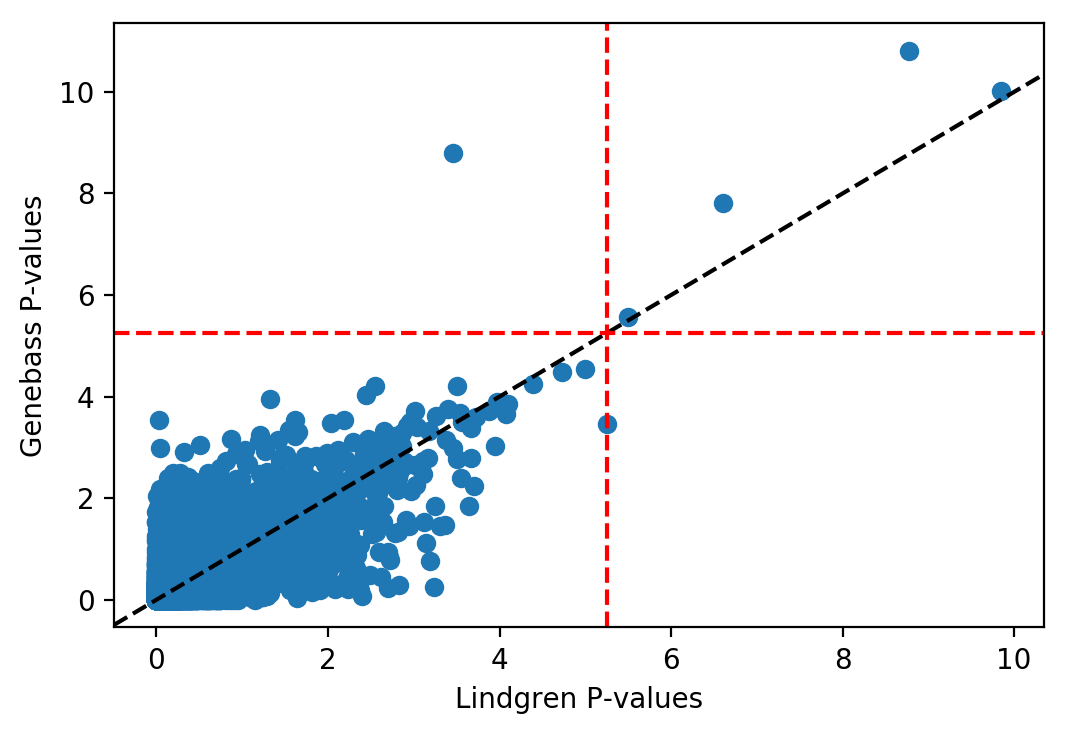

In [50]:
plt.figure(dpi=200)
plt.scatter(-np.log10(merge_genebass.Pvalue), -np.log10(merge_genebass.Pvalue_genebass))
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.plot(*[[xmin, xmax]]*2, 'k--')
bonf_nlog10pval = -np.log10(0.05/merge_genebass.shape[0])
plt.plot([bonf_nlog10pval]*2, [ymin, ymax], 'r--')
plt.plot([xmin, xmax], [bonf_nlog10pval]*2, 'r--')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel('Lindgren P-values')
plt.ylabel('Genebass P-values')


In [41]:
np.corrcoef(merge_genebass.Pvalue.values, merge_genebass.Pvalue_genebass.values)

array([[ 1., nan],
       [nan, nan]])